In [209]:
import numpy as np
import math

import torch
import gym

from Helpers import visualize_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
# from numba import jit

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(DEVICE)
torch.manual_seed(24)

torch.__version__, gym.__version__, torch.cuda.is_available(), DEVICE

('2.6.0+cu118', '0.26.2', True, 'cuda')

## Grid Environment
### Instancing grid with size MxN, start position as (start_x, start_y)
### Adding random obstacles 
    0: free
    1: occupied

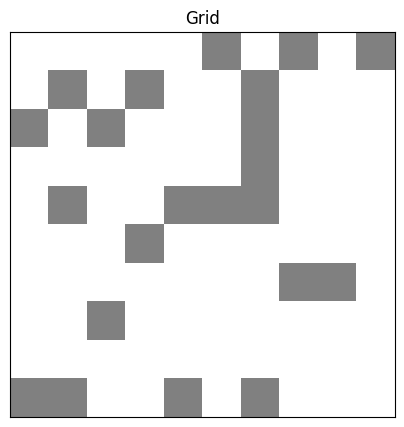

(tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
         [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
         [1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]], device='cuda:0', dtype=torch.int8),
 tensor([0, 0], device='cuda:0', dtype=torch.int8),
 None)

In [232]:
M, N = 10,10
start_x, start_y = 0,0
end_x, end_y = M-1,N-1
start = torch.tensor([start_x,start_y]).type(torch.int8)
grid = (torch.rand((M, N)) > 0.8).type(torch.int8)

#Marking start and end positions as free
grid[start_x, start_y] = 0 
grid[end_x, end_y] = 0

grid, start, visualize_grid(grid)

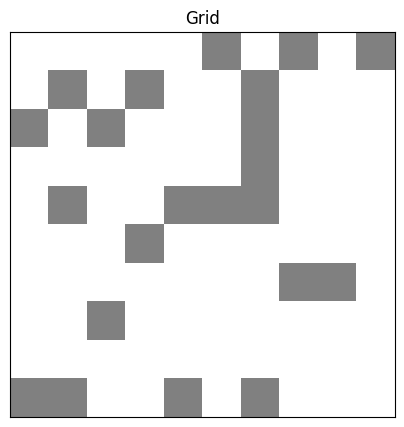

In [233]:
visualize_grid(grid)

### Car State

In [234]:
car_state = torch.tensor([start_x, start_y])
car_state

tensor([0, 0], device='cuda:0')

### Action Space

In [235]:
action_space = {
    "up":np.array([-1,0]),
    "down":np.array([1,0]),
    "right":np.array([0,1]),
    "left":np.array([0,-1])
}
actions = list(action_space.keys())
action_space, actions

({'up': array([-1,  0]),
  'down': array([1, 0]),
  'right': array([0, 1]),
  'left': array([ 0, -1])},
 ['up', 'down', 'right', 'left'])

### Reward Function

In [236]:
def ActionReward_V1(grid, car, action):
    """
    Params -  
    grid: torch tensor of M,N
    car: torch tensor of 2,1
    action: string belonging to any of -> up, down, left, right

    Returns - 
    torch.tensor(car): tensor of shape 2,1
    reward: integer
    msg: string (for debugging steps)
    """
    #Fetching other variables
    global start_x, start_y, end_x, end_y, M, N, action_space, actions
    
    if grid.dim() != 2:
        raise ValueError("Input grid must be a 2D tensor.")
    if car.dim() != 1:
        raise ValueError("Input grid must be a 1D tensor.")
    # if len(action) != 2:
        # raise ValueError("Input grid must be an array of length 2")
    if action not in actions:
        raise ValueError(f"Action must be one of: {list(action_space.keys())}")

    #Getting ordered action value from action space 
    action_value = action_space[action]
    
    # Initializing/converting required variables
    grid = grid.cpu()
    car = car.cpu()
    reward = -1 # Since every move is -1 to minimize steps taken
    msg = "BLANK Hit"

    # From this point, type(CAR) = NP.ARRAY
    car = car.numpy() + action_value

    #Checking out of bounds:
    x, y = car
    # Check if the coordinates are out of bounds
    if x < 0 or x >= M or y < 0 or y >= N:
        reward += -10
        msg = "BOUNDS Exceeded"
        return torch.tensor(car-action_value, dtype=torch.int), reward, msg
    
    # If car has reached the final point:
    if car[0] == end_x and car[1] == end_y:
        reward += 10
        msg = "END Reached"
        
    # If car hits an obstacle:
    if grid[car[0], car[1]] == 1:
        reward += -10
        msg = "OBS Hit"
        return torch.tensor(car - action_value, dtype=torch.int), reward, msg
        
    return torch.tensor(car), reward, msg

def ActionReward(grid, car, action):
    """
    Params -  
    grid: torch tensor of MxN
    car: torch tensor of shape (2,)
    action: string, one of -> "up", "down", "left", "right"

    Returns - 
    torch.tensor(car): Updated car position (2,)
    reward: Integer reward for the action
    msg: String (for debugging steps)
    """
    global start_x, start_y, end_x, end_y, M, N, action_space, actions

    # Input validation
    if grid.dim() != 2:
        raise ValueError("Grid must be a 2D tensor.")
    if car.dim() != 1 or car.shape[0] != 2:
        raise ValueError("Car state must be a 1D tensor of shape (2,).")
    if action not in actions:
        raise ValueError(f"Invalid action: {action}")

    # Get action offset
    action_value = torch.tensor(action_space[action])

    # Apply action
    new_car = car + action_value
    x, y = new_car.tolist()

    # Default reward
    reward = -1  # Encourage minimal steps
    msg = "BLANK Move"

    # Check out-of-bounds
    if x < 0 or x >= M or y < 0 or y >= N:
        reward -= 10
        msg = "BOUNDS Exceeded"
        return car, reward, msg  # Stay in place

    # If car reaches the goal
    if x == end_x and y == end_y:
        reward += 10
        msg = "END Reached"

    # If car hits an obstacle
    elif grid[x, y] == 1:
        reward -= 50
        msg = "OBS Hit"
        return car, reward, msg  # Stay in place

    return torch.tensor([x, y]), reward, msg
# car_state_updated, reward, msg = ActionReward(grid, car_state, "right")
# car_state_updated, reward, msg

### Q-Table (MxNx4)
One value per state-action pair

In [237]:
Q = torch.zeros((M,N,4)) #M = 10, N = 4, GRID is a torch tensor of MxN
gamma = 0.7 #Discount Factor
alpha = 0.1 #Learning rate
epsilon = 0.1 # P(exploring) or 1-P(Exploiting)
num_episodes = 500

### Updating Q-Table

In [238]:
rewards = []
for episode in tqdm(range(num_episodes)):
    car_state = torch.tensor([start_x, start_y])  # Reset agent to start
    done = False

    rewards.append(0)
    while not done:
        x, y = car_state.tolist()

        # Choose action using ε-greedy strategy
        valid_actions = [a for a in actions if ActionReward(grid, car_state, a)[0].tolist() != car_state.tolist()]

        # Choose action using ε-greedy strategy
        if np.random.rand() < epsilon and valid_actions:
            action = np.random.choice(valid_actions)  # Explore only valid moves
        else:
            action = actions[torch.argmax(Q[x, y]).item()]  # Exploit

        # Take action
        new_car, reward, msg = ActionReward(grid, car_state, action)
        new_x, new_y = new_car.tolist()
        action_idx = actions.index(action)

        # Check bounds before updating Q-table
        if (new_x, new_y) != (x, y):  # If movement is valid
            best_future_q = torch.max(Q[new_x, new_y]).item()
        else:
            best_future_q = 0

        # Q-learning update
        Q[x, y, action_idx] += alpha * (reward + gamma * best_future_q - Q[x, y, action_idx])
        rewards[episode] += reward  # Track total reward

        # Update agent position
        car_state = new_car

        # End episode if goal is reached or car hits an obstacle
        if car_state[0] == end_x and car_state[1] == end_y:
            done = True

    # Reduce exploration over time
    epsilon *= 0.99



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.58it/s]


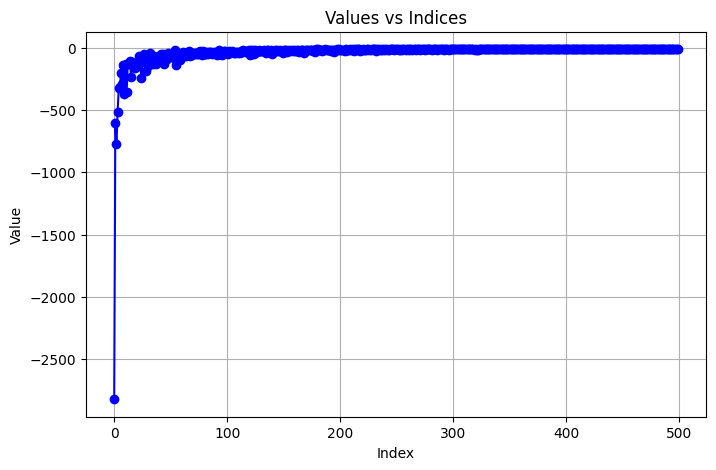

In [239]:
def plot_simple(array, title="Values vs Indices", xlabel="Index", ylabel="Value"):
    """
    Plots the values of a 1D array against their indices.

    :param array: A 1D array (list, NumPy array, or PyTorch tensor).
    :param title: Title of the plot (default: "Values vs Indices").
    :param xlabel: Label for the x-axis (default: "Index").
    :param ylabel: Label for the y-axis (default: "Value").
    """
    # Convert the array to a NumPy array if it's a PyTorch tensor
    if hasattr(array, 'numpy'):  # Check if it's a PyTorch tensor
        array = array.numpy()
    elif not isinstance(array, (list, np.ndarray)):  # Ensure it's a list or NumPy array
        raise ValueError("Input must be a list, NumPy array, or PyTorch tensor.")

    # Create the plot
    plt.figure(figsize=(8, 5))  # Set the figure size
    plt.plot(array, marker='o', linestyle='-', color='b')  # Plot the values
    plt.title(title)  # Add a title
    plt.xlabel(xlabel)  # Add an x-axis label
    plt.ylabel(ylabel)  # Add a y-axis label
    plt.grid(True)  # Add a grid for better readability

    # Show the plot
    plt.show()
plot_simple(rewards)

In [261]:
x,y =1,5
actions[torch.argmax(Q[x,y])], Q[x,y]

('left', tensor([-5.1000, -3.2859, -5.1000, -3.2858], device='cuda:0'))

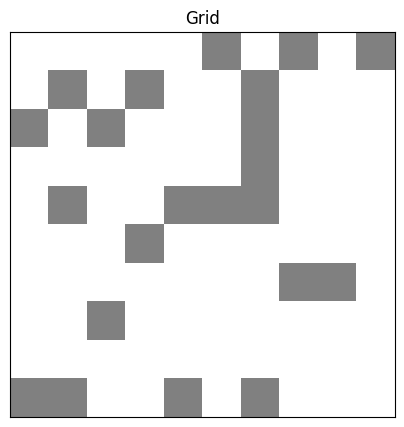

In [240]:
visualize_grid(grid)

In [241]:
grid

tensor([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0]], device='cuda:0', dtype=torch.int8)

In [185]:
Q

tensor([[[-2.9810, -0.8882,  0.8970, -5.1541],
         [-0.5639, -0.5522,  1.5788, -2.9810],
         [-0.5576, -1.1000, -1.1000, -1.1000]],

        [[-2.9810,  2.7100, -2.9810, -0.5452],
         [ 0.0847, -3.7829,  5.3000, -0.3340],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-5.1541,  9.0000,  0.0000,  0.5115],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0')

In [ ]:
grid